In [1]:
import pandas as pd
import os
from multiprocessing import Pool, cpu_count
from tqdm import tqdm
from collections import defaultdict
import numpy as np
import time

In [ ]:
#直接添加在build_features内
did_feature_cols = [col for col in df_did_features.columns if col.startswith('f') and col != 'f87']
# 采样5%用户，提升速度
sampled_user = df_did_features.sample(frac=0.05, random_state=42)
all_user_mean = sampled_user[did_feature_cols].mean().values
all_user_var = sampled_user[did_feature_cols].var().values  # 全体用户特征的方差向量

df_tmp = df_click_filtered.merge(df_vid_info[['vid', 'item_duration']], on='vid', how='left')
df_tmp = df_tmp.merge(df_did_features[did_feature_cols], left_on='did', right_index=True, how='left')
df_tmp['play_rate'] = df_tmp['play_time'] / df_tmp['item_duration']
df_tmp = df_tmp[df_tmp['play_rate'] > 0.1]

vid_audience_feature = {}
vid_audience_var_dist = {}
from numpy.linalg import norm

vid_groups = df_tmp.groupby('vid')
for vid, group in tqdm(vid_groups, total=vid_groups.ngroups, desc="受众特征计算"):
    weights = group['play_rate'].values
    feats = group[did_feature_cols].values
    if feats.shape[0] == 0:
        vid_audience_feature[vid] = 0
        vid_audience_var_dist[vid] = 0
        continue
    if weights.sum() > 0:
        weights = weights / weights.sum()
    else:
        weights = np.ones_like(weights) / len(weights)
    # 加权均值
    weighted_mean = np.average(feats, axis=0, weights=weights)
    # 加权方差
    weighted_var = np.average((feats - weighted_mean) ** 2, axis=0, weights=weights)
    # 均值余弦距离
    cos_sim = np.dot(weighted_mean, all_user_mean) / (norm(weighted_mean) * norm(all_user_mean) + 1e-8)
    cos_dist = 1 - cos_sim
    vid_audience_feature[vid] = cos_dist
    # 多样性（方差向量）与全体用户的余弦距离
    var_cos_sim = np.dot(weighted_var, all_user_var) / (norm(weighted_var) * norm(all_user_var) + 1e-8)
    var_cos_dist = 1 - var_cos_sim
    vid_audience_var_dist[vid] = var_cos_dist

data['vid_audience_cos_dist'] = vid_audience_feature
data['vid_audience_var_dist'] = vid_audience_var_dist

#但是这个特征怎么用啊，没太想好
user_type_click_count = {}
if 'item_type' in df_vid_info.columns:
    vid_to_type = df_vid_info.set_index('vid')['item_type'].to_dict()
    df_click_filtered['item_type'] = df_click_filtered['vid'].map(vid_to_type)
    for (did, item_type), group in df_click_filtered.groupby(['did', 'item_type']):
        user_type_click_count[(did, item_type)] = len(group)
data['user_type_click_count'] = user_type_click_count


In [2]:
# 数据路径
DATA_PATH = r"/home/mi/ms/Data_A/"
CLICK_PATH = os.path.join(DATA_PATH, "用户历史点击数据")
PLAY_PATH = os.path.join(DATA_PATH, "用户历史播放数据")
SHOW_PATH = os.path.join(DATA_PATH, "用户历史曝光数据")
TEST_PRED_PATH = os.path.join(DATA_PATH, "./A榜待预测的did/testA_pred_did.csv")
TEST_SHOW_PATH = os.path.join(DATA_PATH, "./A榜用户曝光数据/testA_did_show.csv")
VID_INFO_PATH = os.path.join(DATA_PATH, "./vid_info/vid_info_table.csv")
DID_FEATURES_PATH = os.path.join(DATA_PATH, "did_features/did_features_table.csv")
DANMU_PATH = os.path.join(DATA_PATH, "弹幕文本数据")
#DATA_PARQUET_PATH = r"C:\Users\xqy16\Desktop\多模态视频推荐\用户历史日志_自加特征"

In [3]:
# 内存优化参数
CHUNK_SIZE = 500000
PARALLEL_JOBS = max(1, cpu_count() - 2)

# 分块加载数据
def load_csv_chunks(file_path, day, dtype=None):
    chunks = []
    for chunk in pd.read_csv(file_path, chunksize=CHUNK_SIZE, dtype=dtype):
        chunk['day'] = day 
        chunks.append(chunk)
    return pd.concat(chunks, ignore_index=True) if chunks else pd.DataFrame()

# 加载曝光点击播放数据
def load_day_data(data_type, day):
    day_str = f"{day:02d}"
    path = {
        "click": os.path.join(CLICK_PATH, f"day{day_str}/day{day_str}_data.csv"),
        "play": os.path.join(PLAY_PATH, f"day{day_str}/day{day_str}_data.csv"),
        "show": os.path.join(SHOW_PATH, f"day{day_str}/did_show_data{day_str}.csv")
    }.get(data_type)
    
    return load_csv_chunks(path, day)

# 读取弹幕数据文件
def read_danmu_files():
    all_dfs = []
    for i in tqdm(range(1, 19), desc="读取弹幕数据文件"): 
        file_name = f"{i}.xlsx"
        file_path = os.path.join(DANMU_PATH, file_name)
        df = pd.read_excel(file_path)
        all_dfs.append(df)
    print("弹幕数据读取完成...")
    result = pd.concat(all_dfs, ignore_index=True)
    del all_dfs
    return result


# 加载弹幕数据
def load_danmu_data():
    df_danmu = read_danmu_files()
    if not df_danmu.empty:  
        df_danmu = df_danmu.rename(columns={'videoid': 'vid'})
        print(f"弹幕数据加载完成，记录总数: {len(df_danmu)}")
    else:
        print("未加载到弹幕数据")
    return df_danmu


# 计算视频弹幕热度
def calculate_danmu_popularity(df_danmu):
    print("计算视频弹幕热度")
    if df_danmu.empty:
        print("弹幕数据为空...")
        return {}
    
    # 按视频统计弹幕数量
    vid_danmu_counts = df_danmu['vid'].value_counts().to_dict()
    
    # 计算弹幕密度（弹幕数量/视频时长）
    df_vid_info = pd.read_csv("./vid_info/vid_info_table.csv")
    vid_to_duration = df_vid_info.set_index('vid')['item_duration'].to_dict()

    vid_density = {}
    for vid, counts in vid_danmu_counts.items():
        duration = vid_to_duration.get(vid, 1000)
        vid_density[vid] = counts / duration
    
    danmu_features = {
        'vid_danmu_count': vid_danmu_counts,
        'vid_danmu_density': vid_density
    }
    
    return danmu_features


# 加载数据
def load_full_data():    
    # 加载点击及播放数据
    print("\n加载点击数据...")
    click_data = []
    for day in tqdm(range(1, 3), desc="天"):
        click = load_day_data("click", day)
        play = load_day_data("play", day)
        
        if not click.empty and not play.empty:
            click = click.merge(play[['did', 'vid', 'play_time']], on=['did', 'vid'], how='left')
        click_data.append(click)
    
    df_click = pd.concat(click_data, ignore_index=True)
    print(f"点击数据加载完成，点击记录总数: {len(df_click)}")
    
    # 加载曝光数据
    print("\n加载曝光数据...")
    show_data = []
    for day in tqdm(range(1, 3), desc="天"):
        show = load_day_data("show", day)
        show_data.append(show)
    
    df_show = pd.concat(show_data, ignore_index=True)
    print(f"曝光数据加载完成，曝光记录总数: {len(df_show)}")
    
    # 加载视频信息
    print("\n加载视频信息...")
    df_vid_info = pd.read_csv(VID_INFO_PATH)
    
    # 合并视频合集信息
    vid_to_item_cid = df_vid_info.set_index('vid')['item_cid'].to_dict()
    df_click['item_cid'] = df_click['vid'].map(vid_to_item_cid).fillna(-1)
    df_show['item_cid'] = df_show['vid'].map(vid_to_item_cid).fillna(-1)
    
    # 加载弹幕数据
    #df_danmu = load_danmu_data()
    #danmu_features = calculate_danmu_popularity(df_danmu)
    
    return df_click, df_show, df_vid_info#, df_danmu#, danmu_features

# 加载用户特征
def load_did_features():
    print("\n加载用户特征...")
    feature_cols = [f"f{i}" for i in range(88)]
    
    # 定义数据类型
    dtype_dict = {col: np.float32 for col in feature_cols if col != 'f87'}
    dtype_dict['f87'] = 'object'  
    dtype_dict['did'] = 'object'
    
    usecols = ['did'] + feature_cols
    df_did = pd.read_csv(DID_FEATURES_PATH, usecols=usecols, dtype=dtype_dict)
    
    # 处理缺失值
    for col in feature_cols:
        if col in df_did.columns:
            if col == 'f87':
                df_did[col] = df_did[col].fillna('null')
            else:
                df_did[col] = df_did[col].fillna(0)
    
    return df_did.set_index('did'), feature_cols



In [4]:
# 构建播放率预测模型特征|
def build_play_rate_features(df_click, df_show, df_vid_info, df_did_features, df_danmu, danmu_features, start_day=21, end_day=30):
    print("\n===== 构建播放率预测模型特征 =====")
    
    # 筛选时间段内的数据
    df_click_filtered = df_click[(df_click['day'] >= start_day) & (df_click['day'] < end_day)].copy()
    df_show_filtered = df_show[(df_show['day'] >= start_day) & (df_show['day'] < end_day)].copy()
    
    # 标记播放行为
    df_click_filtered['played'] = 1
    df_show_filtered['played'] = 0
    
    # 合并点击和曝光数据
    print("合并点击和曝光数据...")
    df_all = pd.concat([
        df_click_filtered[['did', 'vid', 'played']],
        df_show_filtered[['did', 'vid', 'played']]
    ], ignore_index=True)
    
    # 去重
    df_all = df_all.sort_values('played', ascending=False).drop_duplicates(subset=['did', 'vid'])
    
    # 合并用户特征
    print("合并用户特征...")
    df_all = df_all.merge(df_did_features, left_on='did', right_index=True, how='left')
    
    # 合并视频特征
    print("合并视频特征...")
    df_all = df_all.merge(df_vid_info, on='vid', how='left')
    
    
    # 处理缺失值
    print("处理缺失值...")
    df_all.fillna(0, inplace=True)
    
    # 获取用户特征
    did_feature_cols = [col for col in df_did_features.columns if col.startswith('f')]
    video_feature_cols = ['item_type', 'item_duration', 'item_assetSource', 'item_classify', 'item_isIntact']
    
    # 加入弹幕特征列
    danmu_feature_cols = ['vid_danmu_count', 'vid_danmu_density']
    all_feature_cols = did_feature_cols + video_feature_cols + danmu_feature_cols
    
    # 分类特征处理
    print("分类特征处理...")
    categorical_cols = []
    
    for col in did_feature_cols:
        if df_all[col].dtype == 'object' or pd.api.types.is_categorical_dtype(df_all[col]):
            categorical_cols.append(col)
            print(f"用户分类特征: {col}")
    

    encoders = {}
    
    # 对分类特征进行编码（使用LabelEncoder）
    print("对分类特征进行编码...")
    for col in categorical_cols:
        le = LabelEncoder()
        df_all[col] = le.fit_transform(df_all[col].astype(str))
        encoders[col] = le 
    
    # 构建完整特征列表
    valid_feature_cols = []
    for col in all_feature_cols:
        if col in df_all.columns:
            valid_feature_cols.append(col)
        else:
            print(f"特征 {col} 不存在于数据中，将被忽略")
    
    # 优化数据类型以减少内存占用
    for col in valid_feature_cols:
        if df_all[col].dtype == 'float64':
            df_all[col] = df_all[col].astype(np.float32)
        elif df_all[col].dtype == 'int64':
            df_all[col] = df_all[col].astype(np.int32)
    
    print(f"使用的特征列: {valid_feature_cols}")
    
    return df_all, valid_feature_cols, encoders


In [5]:
print("\n===== 开始召回 =====")
start_time = time.time()
print(f"开始时间: {time.ctime()}")

# 加载数据
df_click, df_show, df_vid_info = load_full_data()

# 加载用户特征
df_did_features, _ = load_did_features()

# 划分训练集(1-28)和验证集(29-30)
# print("\n===== 划分训练集和验证集 =====")
# train_click = df_click[df_click['day'] <= 7].copy()
# val_click = df_click[df_click['day'].isin([8, 9])].copy()
# val_show = df_show[df_show['day'].isin([8, 9])].copy()



===== 开始召回 =====
开始时间: Mon Jun 30 19:20:11 2025

加载点击数据...


天: 100%|██████████| 2/2 [00:00<00:00,  3.12it/s]


点击数据加载完成，点击记录总数: 294938

加载曝光数据...


天: 100%|██████████| 2/2 [00:01<00:00,  1.60it/s]


曝光数据加载完成，曝光记录总数: 2838947

加载视频信息...

加载用户特征...


In [ ]:
# 特征工程
def build_features(df_click, df_show, df_danmu, danmu_features, start_date=21, end_date=30):
    print("\n===== 构建特征 =====")
    
    df_click_filtered = df_click[(df_click['day'] >= start_date) & (df_click['day'] < end_date)]
    df_show_filtered = df_show[(df_show['day'] >= start_date) & (df_show['day'] < end_date)]
    
    data = {}
    
    # 用户点击特征
    data['did_click_unique_vid'] = df_click_filtered.groupby('did')['vid'].nunique().to_dict()
    data['did_click_unique_item_cid'] = df_click_filtered.groupby('did')['item_cid'].nunique().to_dict()
    
    # 视频点击特征
    data['vid_click_count'] = df_click_filtered['vid'].value_counts().to_dict()
    data['item_cid_click_count'] = df_click_filtered['item_cid'].value_counts().to_dict()
    
    # 交叉点击特征
    data['did_vid_clicks'] = defaultdict(int)
    for (did, vid), count in df_click_filtered.groupby(['did', 'vid']).size().items():
        data['did_vid_clicks'][(did, vid)] = count
        
    # ===== 受众特征：基于完播率加权的用户特征均值与全体均值的余弦距离 =====
    print("计算视频受众特征...")
    # 需要 did_features（用户特征表）和视频时长
    if 'df_vid_info' in globals() and 'df_did_features' in globals():
        did_feature_cols = [col for col in df_did_features.columns if col.startswith('f')]
        # 计算所有用户特征均值向量
        all_user_mean = df_did_features[did_feature_cols].mean().values

        # 先合并点击表和视频时长
        df_tmp = df_click_filtered.merge(df_vid_info[['vid', 'item_duration']], on='vid', how='left')
        df_tmp = df_tmp.merge(df_did_features[did_feature_cols], left_on='did', right_index=True, how='left')
        df_tmp['play_rate'] = df_tmp['play_time'] / df_tmp['item_duration']
        df_tmp = df_tmp[df_tmp['play_rate'] > 0.1]

        vid_audience_feature = {}
        from numpy.linalg import norm

        for vid, group in df_tmp.groupby('vid'):
            weights = group['play_rate'].values
            feats = group[did_feature_cols].values
            if feats.shape[0] == 0:
                vid_audience_feature[vid] = 0
                continue
            # 加权均值
            weighted_mean = np.average(feats, axis=0, weights=weights)
            # 余弦距离
            cos_sim = np.dot(weighted_mean, all_user_mean) / (norm(weighted_mean) * norm(all_user_mean) + 1e-8)
            cos_dist = 1 - cos_sim
            vid_audience_feature[vid] = cos_dist

        data['vid_audience_cos_dist'] = vid_audience_feature
    else:
        print("缺少 df_vid_info 或 df_did_features，无法计算受众特征")
        data['vid_audience_cos_dist'] = {}
    # 计算CTR特征
    print("计算视频CTR...")
    df_all = pd.concat([
        df_click[['did', 'vid', 'item_cid']].assign(action='click'),
        df_show[['did', 'vid', 'item_cid']].assign(action='show')
    ], ignore_index=True)
    
    # 分块计算CTR
    vid_stats = defaultdict(lambda: {'clicks': 0, 'impressions': 0})
    for i in range(0, len(df_all), CHUNK_SIZE):
        chunk = df_all.iloc[i:i+CHUNK_SIZE]
        for vid, group in chunk.groupby('vid'):
            clicks = (group['action'] == 'click').sum()
            impressions = len(group)
            vid_stats[vid]['clicks'] += clicks
            vid_stats[vid]['impressions'] += impressions
    
    # 转换为CTR字典
    data['vid_ctr'] = {
        vid: stats['clicks'] / stats['impressions'] if stats['impressions'] > 0 else 0
        for vid, stats in vid_stats.items()
    }
    
    # 释放内存
    del df_all, vid_stats
    
    return data

In [ ]:
data = {}
# ...existing code...

# ===== 受众特征：基于完播率加权的用户特征均值与全体均值的余弦距离 =====
print("计算视频受众特征...")
if 'df_vid_info' in globals() and 'df_did_features' in globals():
    did_feature_cols = [col for col in df_did_features.columns if col.startswith('f')]
    all_user_mean = df_did_features[did_feature_cols].mean().values

    df_tmp = df_click_filtered.merge(df_vid_info[['vid', 'item_duration']], on='vid', how='left')
    df_tmp = df_tmp.merge(df_did_features[did_feature_cols], left_on='did', right_index=True, how='left')
    df_tmp['play_rate'] = df_tmp['play_time'] / df_tmp['item_duration']
    df_tmp = df_tmp[df_tmp['play_rate'] > 0.1]

    vid_audience_feature = {}
    vid_audience_var = {} 
    from numpy.linalg import norm

    vid_groups = df_tmp.groupby('vid')
    for vid, group in tqdm(vid_groups, total=vid_groups.ngroups, desc="受众特征计算"):
        weights = group['play_rate'].values
        feats = group[did_feature_cols].values
        if feats.shape[0] == 0:
            vid_audience_feature[vid] = 0
            vid_audience_var[vid] = 0
            continue
        weighted_mean = np.average(feats, axis=0, weights=weights)
        weighted_var = np.average((feats - weighted_mean) ** 2, axis=0, weights=weights)
        cos_sim = np.dot(weighted_mean, all_user_mean) / (norm(weighted_mean) * norm(all_user_mean) + 1e-8)
        cos_dist = 1 - cos_sim
        vid_audience_feature[vid] = cos_dist

    data['vid_audience_cos_dist'] = vid_audience_feature
else:
    print("缺少 df_vid_info 或 df_did_features，无法计算受众特征")
    data['vid_audience_cos_dist'] = {}

# ...existing code...

In [12]:
did_feature_cols = [col for col in df_did_features.columns if col.startswith('f')and col != 'f87']  # 排除 'f87' 列
sampled_user = df_did_features.sample(frac=0.05, random_state=42)
all_user_mean = sampled_user[did_feature_cols].mean().values


In [16]:
    
df_tmp = df_click.merge(df_vid_info[['vid', 'item_duration']], on='vid', how='left')
df_tmp = df_tmp.merge(df_did_features[did_feature_cols], left_on='did', right_index=True, how='left')
df_tmp['play_rate'] = df_tmp['play_time'] / df_tmp['item_duration']
# df_tmp = df_tmp[df_tmp['play_rate'] > 0.1]

vid_audience_feature = {}
from numpy.linalg import norm

In [22]:
    vid_groups = df_tmp.groupby('vid')
    for vid, group in tqdm(vid_groups, total=vid_groups.ngroups, desc="受众特征计算"):
        weights = group['play_rate'].values
        feats = group[did_feature_cols].values
        if feats.shape[0] == 0:
            vid_audience_feature[vid] = 0
            continue
        weighted_mean = np.average(feats, axis=0, weights=weights)
        cos_sim = np.dot(weighted_mean, all_user_mean) / (norm(weighted_mean) * norm(all_user_mean) + 1e-8)
        cos_dist = 1 - cos_sim
        vid_audience_feature[vid] = cos_dist

    data['vid_audience_cos_dist'] = vid_audience_feature

受众特征计算: 100%|██████████| 6242/6242 [00:01<00:00, 4192.55it/s]


In [23]:
data['vid_audience_cos_dist']

{852961: np.float64(0.8329892654428962),
 861277: np.float64(0.8596820237238931),
 892543: np.float64(0.951113350972876),
 1148463: np.float64(0.7847931080766366),
 1223502: np.float64(0.846107643324458),
 1232082: np.float64(0.8430448742441095),
 1266474: np.float64(0.7945512601030792),
 1266478: np.float64(0.8203866680164464),
 1266491: np.float64(0.8469560507905627),
 1268348: np.float64(nan),
 1268350: np.float64(0.8436558546426174),
 1268351: np.float64(0.8242869739703956),
 1268352: np.float64(0.8299316810073036),
 1268354: np.float64(0.8178274158680772),
 1268357: np.float64(0.8458022000884979),
 1268358: np.float64(nan),
 1268359: np.float64(nan),
 1268360: np.float64(nan),
 1268361: np.float64(0.8677855603746122),
 1268364: np.float64(nan),
 1268368: np.float64(0.8219775220165019),
 1268369: np.float64(nan),
 1268372: np.float64(nan),
 1268374: np.float64(0.8152371204392733),
 1268375: np.float64(0.8247821470440843),
 1268380: np.float64(0.8200627670338334),
 1268381: np.float

In [17]:
df_tmp['play_rate']

0         0.086789
1         0.003844
2         0.105306
3         0.384166
4         0.080663
            ...   
294933    0.027309
294934    0.313966
294935    0.009897
294936    0.006965
294937    0.004582
Name: play_rate, Length: 294938, dtype: float64

/home/mi/miniforge3/envs/wan/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/mi/miniforge3/envs/wan/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 24067 (\N{CJK UNIFIED IDEOGRAPH-5E03}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/mi/miniforge3/envs/wan/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 30452 (\N{CJK UNIFIED IDEOGRAPH-76F4}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/mi/miniforge3/envs/wan/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 26041 (\N{CJK UNIFIED IDEOGRAPH-65B9}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/mi/miniforge3/envs/wan/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: G

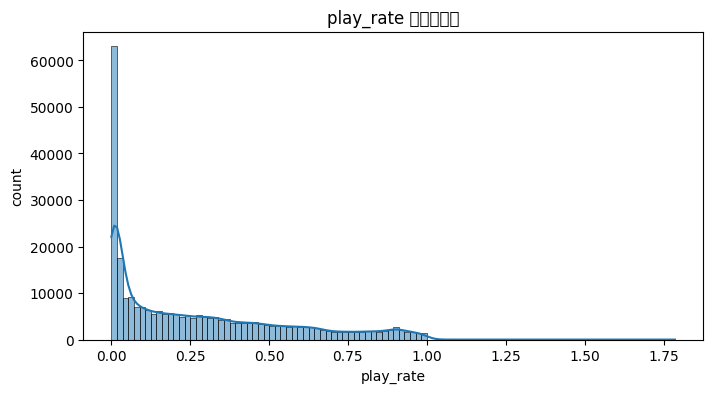

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 4))
sns.histplot(df_tmp['play_rate'], bins=100, kde=True)
plt.xlabel('play_rate')
plt.ylabel('count')
plt.title('play_rate 分布直方图')
plt.show()

In [21]:
#25%下分位数
q25 = df_tmp['play_rate'].quantile(0.50)
print(f"25%下分位数: {q25}")

25%下分位数: 0.18386702019171935


In [ ]:
user_type_click_count = {}
if 'item_type' in df_vid_info.columns:
    vid_to_type = df_vid_info.set_index('vid')['item_type'].to_dict()
    df_click['item_type'] = df_click['vid'].map(vid_to_type)
    for (did, item_type), group in df_click.groupby(['did', 'item_type']):
        user_type_click_count[(did, item_type)] = len(group)
data['user_type_click_count'] = user_type_click_count



NameError: name 'data' is not defined

In [11]:
user_type_click_count

{('000098cabe490a5bd6773009400a9a92', np.int64(0)): 1,
 ('00009c62fa45e67566af9cd926e047b0', np.int64(2)): 1,
 ('0000a93d6cd3a41fdab4239444621b5b', np.int64(0)): 2,
 ('0000bbd1e80ebd1affc3d113afe422f7', np.int64(0)): 1,
 ('0000bbd1e80ebd1affc3d113afe422f7', np.int64(2)): 1,
 ('0000dd2ce9e15fcc3aeae09a4704b1a831f7ad6b', np.int64(2)): 1,
 ('0000f119c925d3755162049f39bedb08', np.int64(0)): 1,
 ('000116584f74f0c254784500033f8dd127877af1', np.int64(0)): 1,
 ('00020053c9c450e04df62b61400c8308', np.int64(0)): 1,
 ('00024d3273a0cfc38390d32e71ac625f', np.int64(0)): 1,
 ('0002737c2c63f6fcfcae56af976059ef5b3ef697', np.int64(0)): 1,
 ('000296c7cf248a3302fd56aef174e32fdf56fb59', np.int64(0)): 2,
 ('0002af23a1a20955329925a13a1c5c4b2295086e', np.int64(0)): 1,
 ('0002af23a1a20955329925a13a1c5c4b2295086e', np.int64(2)): 1,
 ('0002b0261a00b44f970e08fb73b90917', np.int64(0)): 1,
 ('0002b0d96ed78085bf511ad212a762c5860a8fbc', np.int64(0)): 2,
 ('0002be48a1244e1d483319ca93902879bd4894bf', np.int64(0)): 1,
 

In [9]:
vid_to_type

{23153575: 0,
 22196399: 0,
 21274483: 0,
 20760459: 0,
 5237807: 0,
 7393957: 0,
 15978957: 0,
 18615439: 0,
 11505296: 0,
 20594197: 0,
 17604783: 0,
 14580030: 0,
 18594039: 0,
 21462965: 0,
 5259367: 0,
 23098433: 2,
 20687071: 0,
 22573215: 0,
 18534947: 0,
 23182479: 0,
 20398295: 0,
 7747064: 0,
 17665333: 0,
 15978965: 0,
 23090051: 0,
 20160207: 0,
 17735499: 0,
 11761238: 0,
 10847925: 0,
 21997415: 0,
 20009415: 0,
 22201723: 0,
 18900175: 0,
 20576723: 0,
 22210447: 0,
 18866619: 0,
 22980673: 0,
 17967367: 0,
 10181476: 0,
 6599484: 0,
 21918683: 0,
 21065285: 0,
 5718463: 0,
 10101347: 0,
 23096259: 0,
 20930879: 0,
 20736931: 0,
 22095421: 0,
 17661527: 0,
 19782823: 0,
 19870287: 0,
 14577869: 0,
 12547762: 0,
 17170491: 0,
 22057579: 0,
 21354033: 0,
 15853729: 0,
 18260411: 2,
 11174454: 0,
 23045151: 2,
 5587211: 0,
 12306786: 0,
 22967481: 0,
 16517364: 0,
 22885143: 0,
 21773159: 0,
 15391599: 0,
 19685369: 0,
 18258123: 0,
 21052903: 0,
 18881205: 0,
 21849587: 0,

In [10]:
df_vid_info

,vid,item_cid,item_type,item_duration,item_assetSource,item_classify,item_isIntact,item_serialno,sid,stype
0,23153575,1663282,0,4987,0,1,1,11,22611880,0
1,22196399,1574555,0,2721,0,2,1,12,21649336,0
2,21274483,1551346,0,5851,0,1,1,13,20717996,0
3,20760459,1535208,0,2695,0,1,1,4,20196168,0
4,5237807,1257364,0,5901,0,1,1,13,4682739,0
...,...,...,...,...,...,...,...,...,...,...
15784,6645159,1261648,0,1774,0,2,1,23,6122006,0
15785,21749219,1566317,2,1020,0,1,1,45,10665169,2
15786,17931795,931765,2,990,0,0,0,0,261532,2
15787,22286757,1622635,0,332,3,2,1,20,21730026,0
